In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurkal

import itertools
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import seaborn as sns

In [26]:
# make Numpy raise warnings as exceptions
np.seterr(all='warn')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

In [3]:
## Plot style setup
#rc('mathtext', default='regular')
#rcParams.update({'figure.autolayout': True})
sns.set_style("ticks")
#set_palette = lambda: itertools.cycle(sns.color_palette("cubehelix", 8))
set_palette = lambda: itertools.cycle(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))

In [4]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(x - x_i) - 1)) + 0.01)

In [85]:
# simulation parameters
p = 20  # units in input networks
t_f = 10  # total time
dt = 0.01  # timestep
ts = np.arange(0, t_f, dt)

In [33]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[0.003]]   # constant "motor" dynamics
Z = [[0.00005]]  # motor noise variance
c = 1
c_ = np.array([[c]])

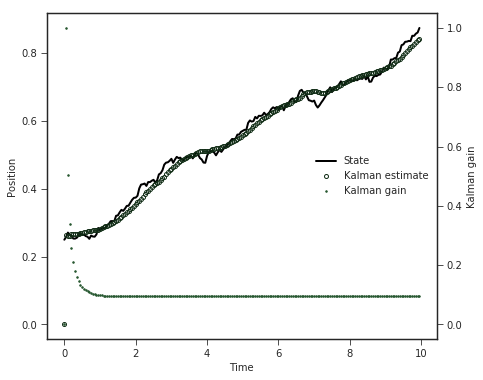

In [91]:
## test conventional kalman filter
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)
# sensory noise
sensory_variance = 0.005

states = []
estimates = []
gains = []
ts = np.arange(0, t_f, 0.05)
for t in ts:
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, sensory_variance)
    kalman.step(c_, x_s, Q=[[sensory_variance]])
    state.update(c_)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Kalman gain", ms=3)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

/home/matthew/dev/neurkal/neurkal/utils.py:15: RuntimeWarning: invalid value encountered in double_scalars
  pv_x = np.dot(activity, np.cos(prefs)) / act_sum
/home/matthew/dev/neurkal/neurkal/utils.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pv_y = np.dot(activity, np.sin(prefs)) / act_sum


IndexError: list index out of range

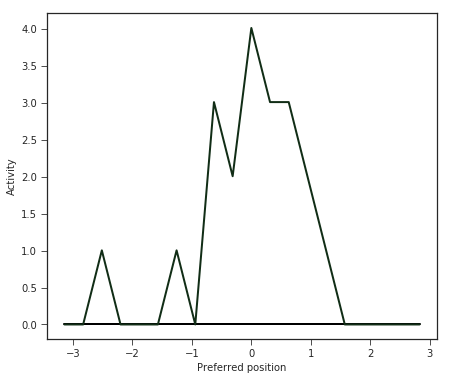

In [94]:
## Kalman network test -- only initial feedback
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=B)
# conventional kalman filter to provide sigma
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)

activities = []
hs = []
us = []
lams = []
ksigs = []
crs = []

sensory_input(state.x[0])
for t in ts:
    activities.append(np.copy(kalman_network.activity))
    hs.append(np.copy(kalman_network._h))
    lams.append(np.copy(kalman_network.lam))
    ksigs.append(np.copy(kalman.sigma))
    crs.append(sensory_input.cr_bound)
    # update conventional kalman filter to get sigma
    kalman.step(c_, [[sensory_input.readout()]], Q=[[sensory_input.cr_bound]])
    # update activity in basis network implementing Kalman filter
    kalman_network.update(kalman.sigma)
    us.append(np.copy(kalman_network._u))
    # update real state (+ control noise)
    state.update(c_)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
ps.append(ax1.plot(prefs, activities[0], '-', color=next(palette), lw=2, label=str(i))[0])
for i in np.linspace(1, int(t_f/dt) - 1, 5).tolist():
    ps.append(ax1.plot(prefs, activities[int(i)], '-', color=next(palette), lw=2, label=str(i))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

/home/matthew/dev/neurkal/neurkal/utils.py:15: RuntimeWarning: invalid value encountered in double_scalars
  pv_x = np.dot(activity, np.cos(prefs)) / act_sum
/home/matthew/dev/neurkal/neurkal/utils.py:16: RuntimeWarning: invalid value encountered in double_scalars
  pv_y = np.dot(activity, np.sin(prefs)) / act_sum


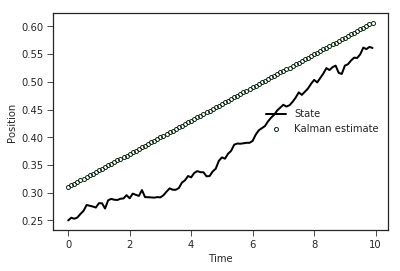

In [61]:
## Kalman network test: initial state only
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=-np.array(B))
# conventional kalman filter to provide sigma
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)

states = []
estimates = []
gains = []

sensory_input(state.x[0])
for t in ts:
    states.append(state.x[0])
    # update conventional kalman filter to get sigma
    kalman.step(c_, [[sensory_input.readout()]], Q=[[sensory_input.cr_bound]])
    # update activity in basis network implementing Kalman filter
    kalman_network.update(kalman.sigma)
    estimates.append(kalman_network.readout())
    # update real state (+ control noise)
    state.update(c_)
    if not t:
        sensory_input.clear()
    
palette = set_palette()
fig, ax1 = plt.subplots()#figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

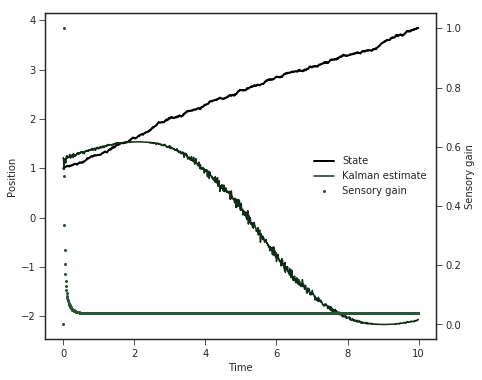

In [79]:
## Kalman network test: state estimates at each timestep
# initial state
x0 = 1
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=np.array(B))
# conventional kalman filter to provide sigma
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)

states = []
estimates = []
gains = []


for t in ts:
    sensory_input(state.x[0])
    states.append(state.x[0])
    gains.append(kalman_network.lam[0])
    # update conventional kalman filter to get sigma
    kalman.step(c_, [[sensory_input.readout()]], Q=[[sensory_input.cr_bound]])
    # update activity in basis network implementing Kalman filter
    kalman_network.update(kalman.sigma)
    estimates.append(kalman_network.readout())
    # update real state (+ control noise)
    state.update(c_)
    
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '-', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Sensory gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Sensory gain", ms=4)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()